In [9]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")

TICKERS = ["AEP", "DUK", "SO", "ED", "EXC"]
EXOG_TICKER = "CL=F"

# horizon = จำนวนวันที่เราจะใช้เป็น test set
FORECAST_HORIZONS = {"1wk": 5, "6mo": 126, "1y": 252}  
RESULTS = []


In [10]:
# ---------------------------------------------------
# Forecast functions
# ---------------------------------------------------
def forecast_arima(train, steps=7, order=(0,1,0)):
    model = ARIMA(train, order=order).fit()
    return model.forecast(steps=steps)

def forecast_sarima(train, steps=7, order=(1,1,1), seasonal_order=(1,1,0,12)):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    return model.forecast(steps=steps)

def forecast_sarimax(train, steps=7, exog_train=None, exog_future=None,
                     order=(1,1,1), seasonal_order=(1,0,1,12)):
    model = SARIMAX(train, exog=exog_train,
                    order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    return model.forecast(steps=steps, exog=exog_future)


=== AEP ===


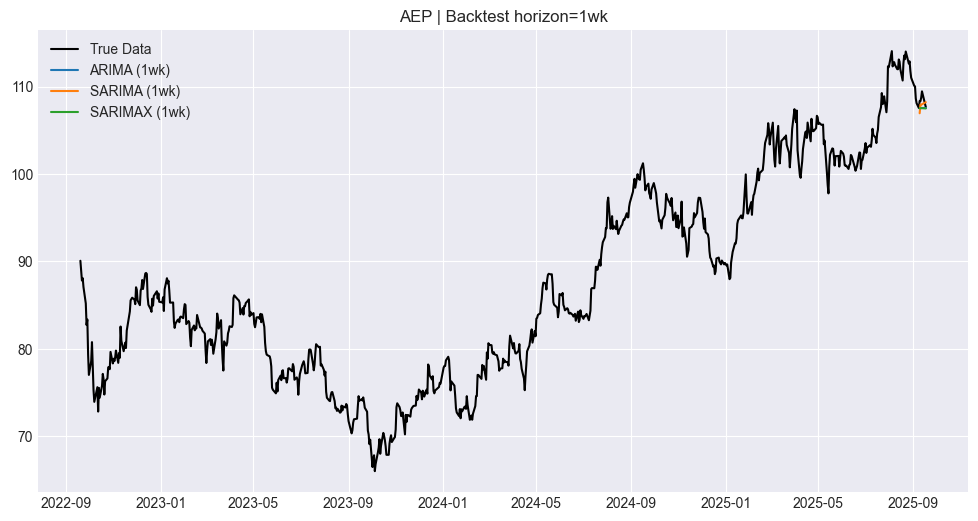

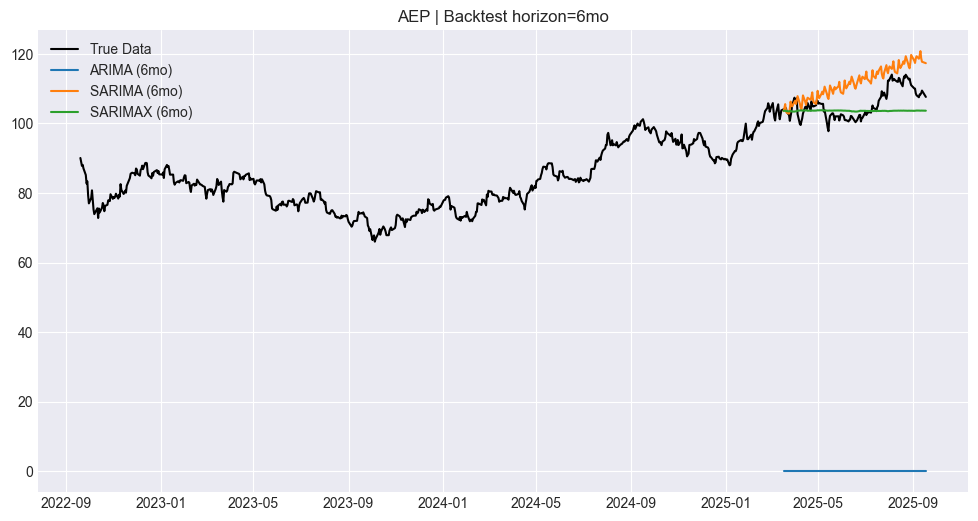

ARIMA error: Found input variables with inconsistent numbers of samples: [126, 252]


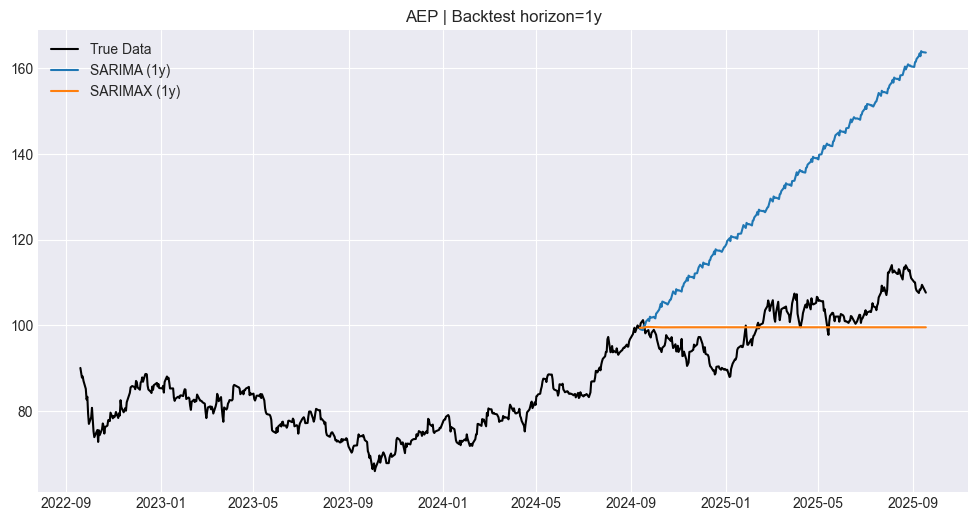


=== DUK ===


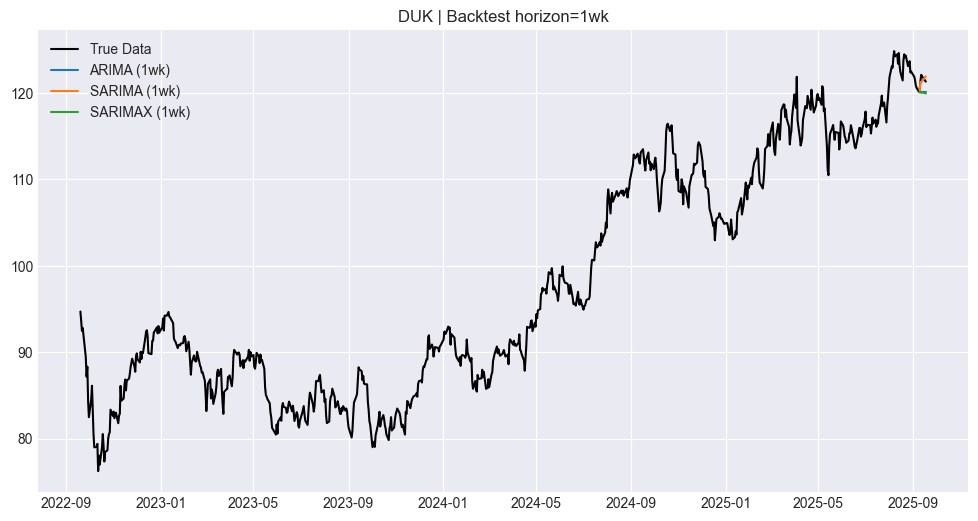

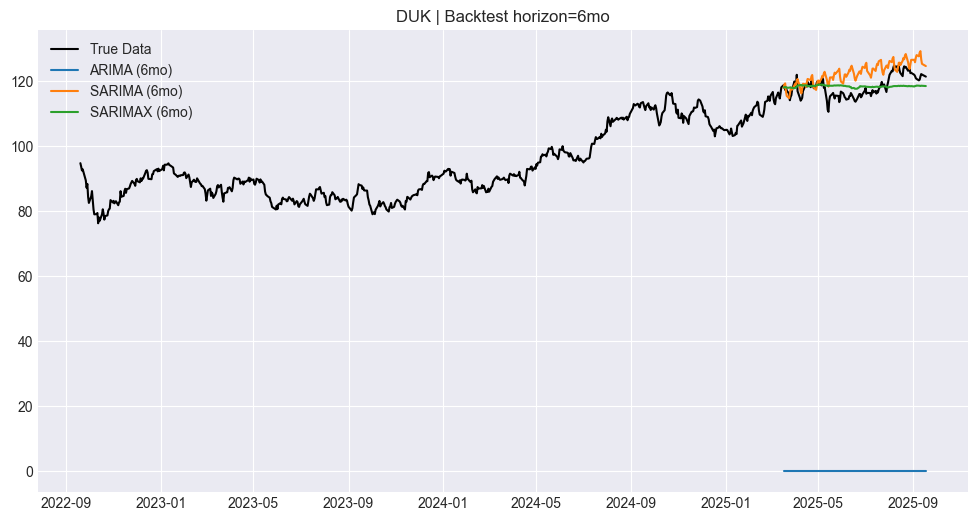

ARIMA error: Found input variables with inconsistent numbers of samples: [126, 252]


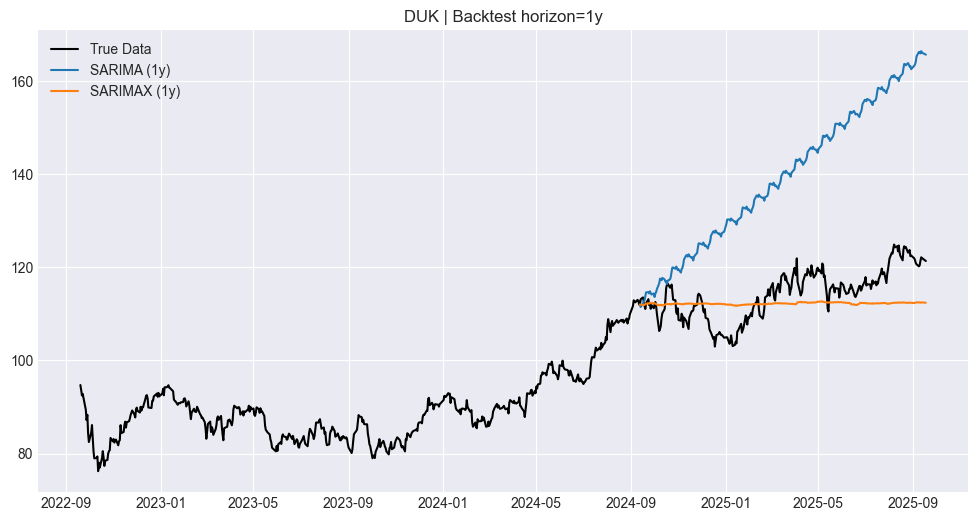


=== SO ===


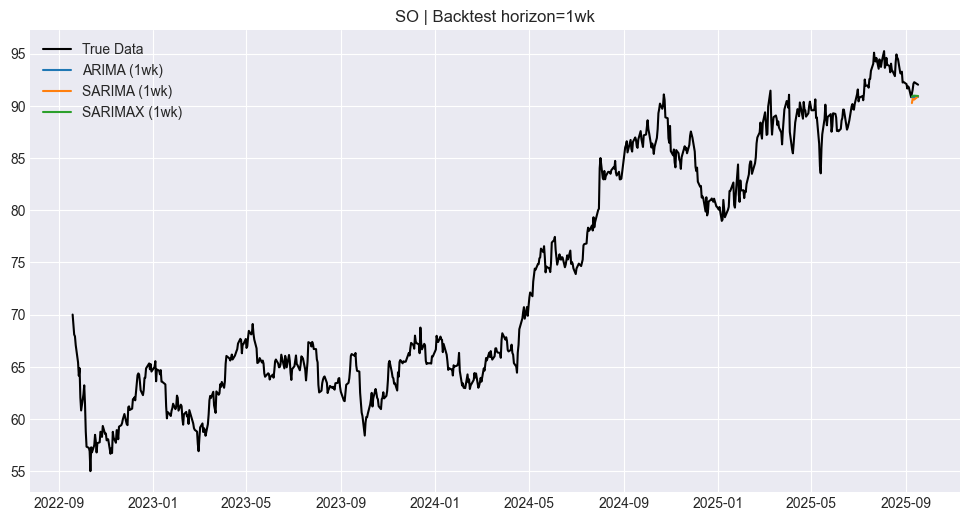

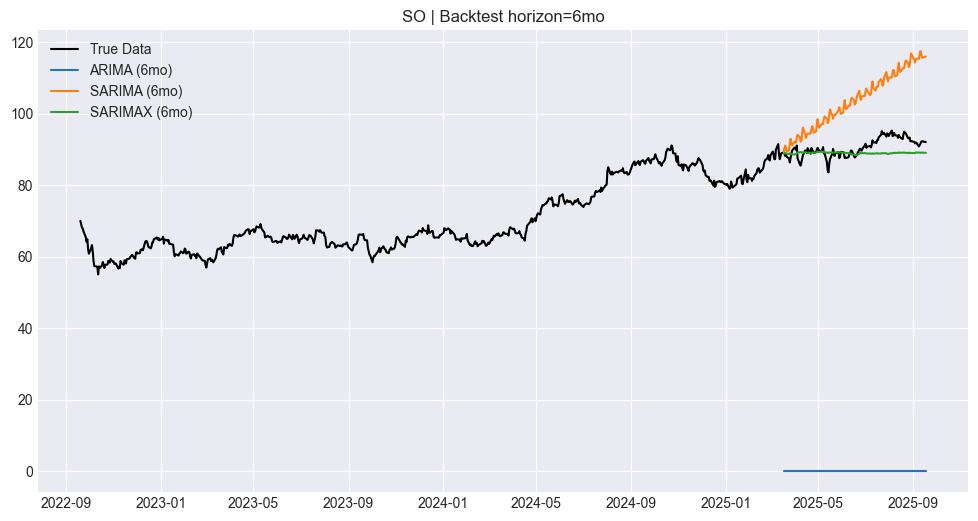

ARIMA error: Found input variables with inconsistent numbers of samples: [126, 252]


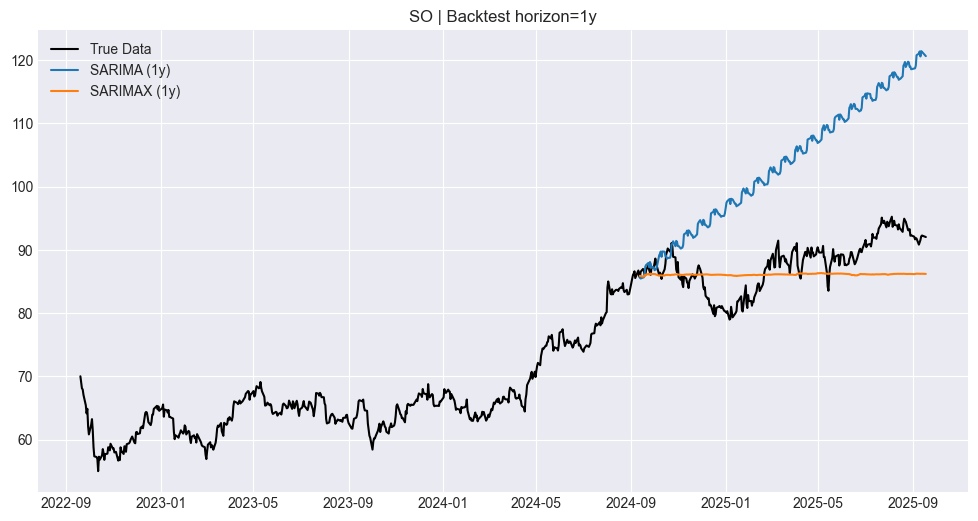


=== ED ===


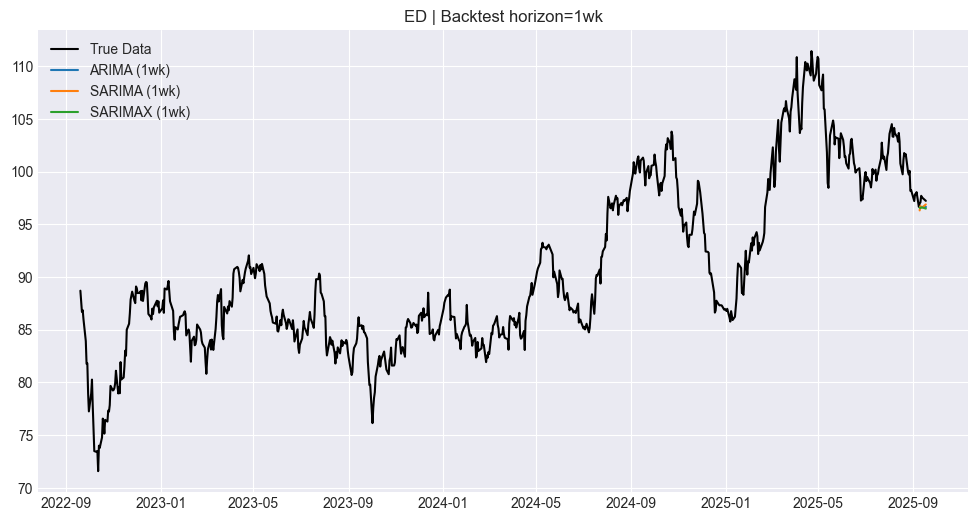

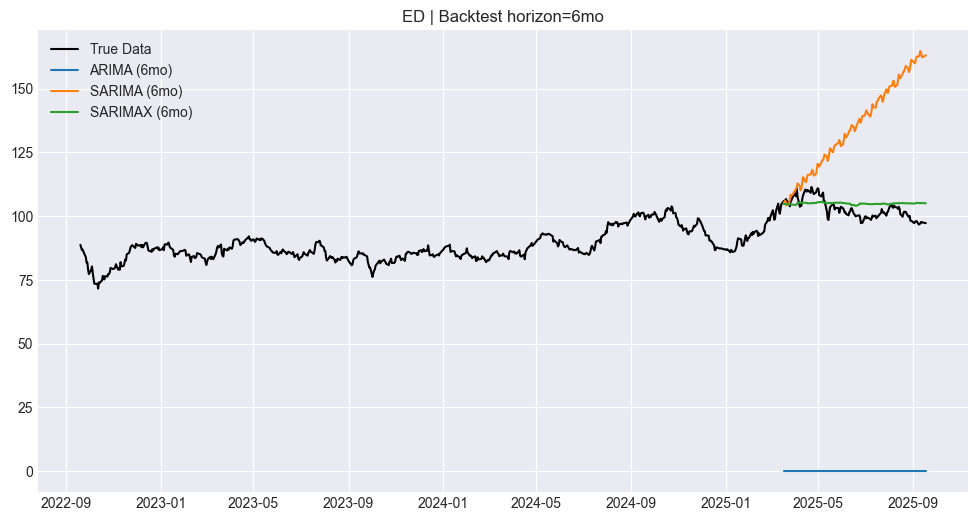

ARIMA error: Found input variables with inconsistent numbers of samples: [126, 252]


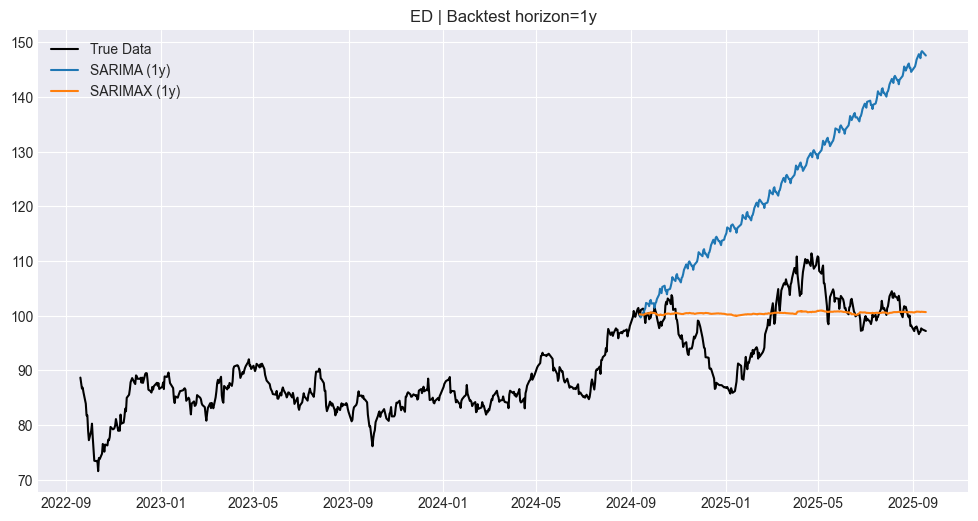


=== EXC ===


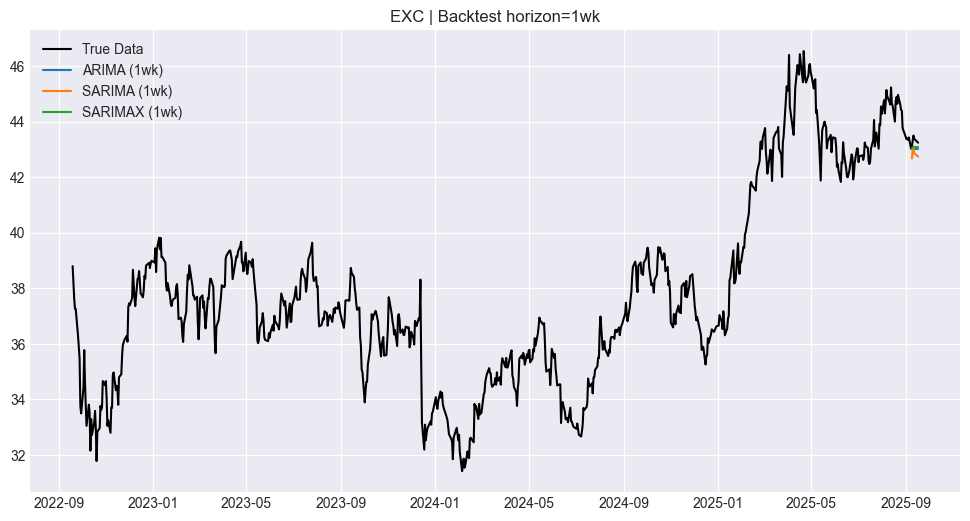

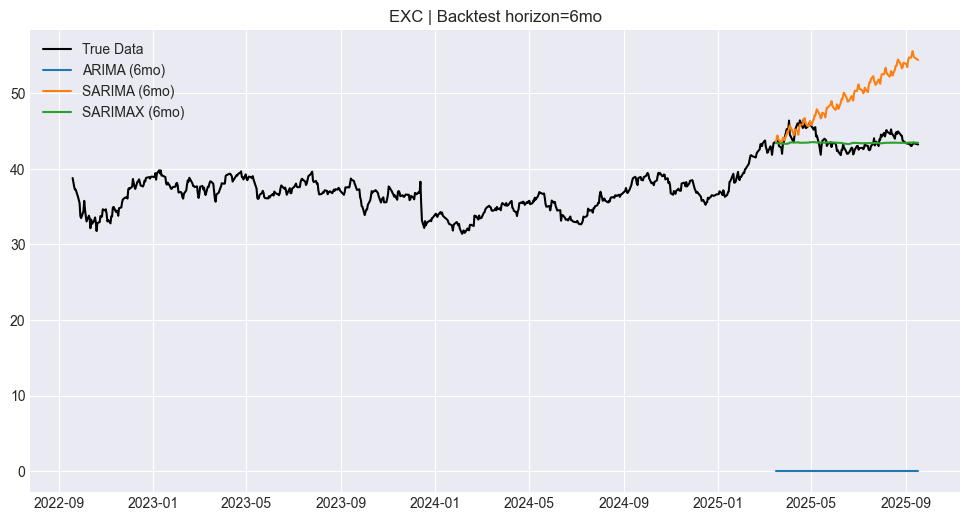

ARIMA error: Found input variables with inconsistent numbers of samples: [126, 252]


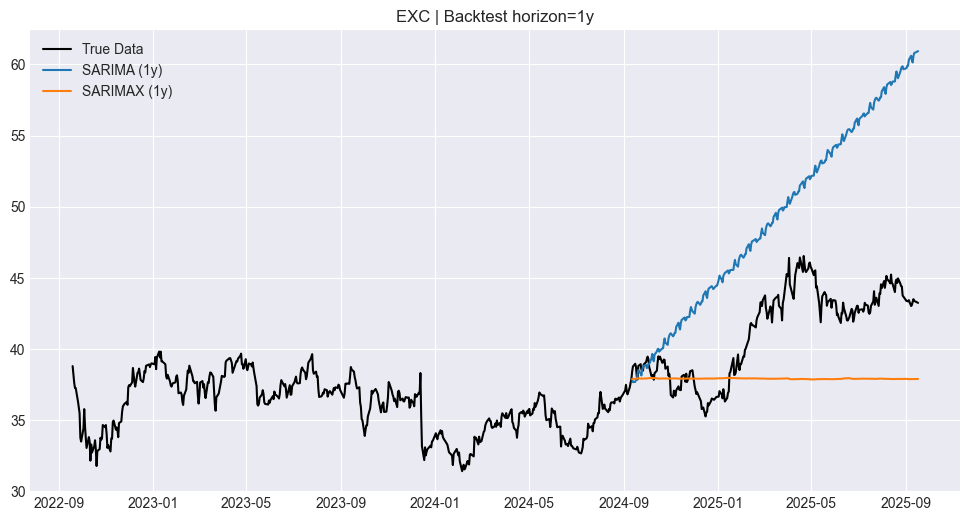

In [11]:
# ---------------------------------------------------
# Load exogenous (3y)
# ---------------------------------------------------
exog_all = yf.download(EXOG_TICKER, period="3y", auto_adjust=True, progress=False)[["Close"]]
exog_all.rename(columns={"Close": "EXOG"}, inplace=True)

# ---------------------------------------------------
# Backtest
# ---------------------------------------------------
for ticker in TICKERS:
    print(f"\n=== {ticker} ===")

    # ARIMA ใช้ 6mo
    df_arima = yf.download(ticker, period="6mo", auto_adjust=True, progress=False)
    series_arima = df_arima["Close"].dropna()

    # SARIMA/SARIMAX ใช้ 3y
    df_long = yf.download(ticker, period="3y", auto_adjust=True, progress=False)
    series_long = df_long["Close"].dropna()
    exog = exog_all.loc[series_long.index].fillna(method="ffill")

    for label, horizon in FORECAST_HORIZONS.items():
        preds = {}
        metrics = {}

        # ------------------- ARIMA -------------------
        try:
            train, test = series_arima[:-horizon], series_arima[-horizon:]
            pred = forecast_arima(train, steps=horizon)
            preds["ARIMA"] = pred
            metrics["ARIMA_RMSE"] = np.sqrt(mean_squared_error(test, pred))
            metrics["ARIMA_MAE"] = mean_absolute_error(test, pred)
        except Exception as e:
            preds["ARIMA"] = None
            metrics["ARIMA_RMSE"], metrics["ARIMA_MAE"] = np.nan, np.nan
            print("ARIMA error:", e)

        # ------------------- SARIMA -------------------
        try:
            train, test = series_long[:-horizon], series_long[-horizon:]
            pred = forecast_sarima(train, steps=horizon)
            preds["SARIMA"] = pred
            metrics["SARIMA_RMSE"] = np.sqrt(mean_squared_error(test, pred))
            metrics["SARIMA_MAE"] = mean_absolute_error(test, pred)
        except Exception as e:
            preds["SARIMA"] = None
            metrics["SARIMA_RMSE"], metrics["SARIMA_MAE"] = np.nan, np.nan
            print("SARIMA error:", e)

        # ------------------- SARIMAX -------------------
        try:
            train, test = series_long[:-horizon], series_long[-horizon:]
            exog_train, exog_future = exog.iloc[:-horizon], exog.iloc[-horizon:]
            pred = forecast_sarimax(train, steps=horizon, exog_train=exog_train, exog_future=exog_future)
            preds["SARIMAX"] = pred
            metrics["SARIMAX_RMSE"] = np.sqrt(mean_squared_error(test, pred))
            metrics["SARIMAX_MAE"] = mean_absolute_error(test, pred)
        except Exception as e:
            preds["SARIMAX"] = None
            metrics["SARIMAX_RMSE"], metrics["SARIMAX_MAE"] = np.nan, np.nan
            print("SARIMAX error:", e)

        # เก็บผล
        RESULTS.append({"Ticker": ticker, "Horizon": label, **metrics})

        # ------------------- Plot -------------------
        plt.figure(figsize=(12,6))
        plt.plot(series_long.index, series_long, label="True Data", color="black")
        for m, pred in preds.items():
            if pred is not None:
                plt.plot(test.index, pred, label=f"{m} ({label})")
        plt.title(f"{ticker} | Backtest horizon={label}")
        plt.legend()
        plt.show()

In [13]:
# %%
df_results = pd.DataFrame(RESULTS)

# จัดลำดับ column
cols = ["Ticker", "Horizon",
        "ARIMA_RMSE","ARIMA_MAE",
        "SARIMA_RMSE","SARIMA_MAE",
        "SARIMAX_RMSE","SARIMAX_MAE"]
df_results = df_results[cols]

# แสดงตาราง pivot RMSE
table_rmse = df_results.pivot(index=["Ticker"], columns="Horizon", 
                              values=["ARIMA_RMSE","SARIMA_RMSE","SARIMAX_RMSE"])

# แสดงตาราง pivot MAE
table_mae = df_results.pivot(index=["Ticker"], columns="Horizon", 
                             values=["ARIMA_MAE","SARIMA_MAE","SARIMAX_MAE"])

print("\n===== RMSE Table =====")
display(table_rmse.round(4))

print("\n===== MAE Table =====")
display(table_mae.round(4))



===== RMSE Table =====


ARIMA_RMSE               SARIMA_RMSE                   SARIMAX_RMSE  \
Horizon        1wk  1y       6mo         1wk       1y      6mo          1wk   
Ticker                                                                        
AEP         1.1272 NaN  105.6339      1.0297  33.7337   7.1487       1.1434   
DUK         1.3922 NaN  118.2678      0.5467  27.7944   5.1501       1.5118   
ED          0.7115 NaN  103.0024      0.7440  28.1100  37.6696       0.7887   
EXC         0.3173 NaN   43.8374      0.4420   9.2007   6.6015       0.2633   
SO          1.0845 NaN   90.5056      1.2530  17.6998  14.4000       0.9694   

                         
Horizon      1y     6mo  
Ticker                   
AEP      6.4924  4.5789  
DUK      5.5431  3.2084  
ED       6.0084  4.3308  
EXC      4.5558  1.1989  
SO       4.2411  2.9740


===== MAE Table =====


ARIMA_MAE               SARIMA_MAE                   SARIMAX_MAE  \
Horizon       1wk  1y       6mo        1wk       1y      6mo         1wk   
Ticker                                                                     
AEP         0.958 NaN  105.5516     0.9309  30.6374   6.1642      0.9830   
DUK         1.252 NaN  118.2234     0.4536  24.9807   4.3222      1.3818   
ED          0.656 NaN  102.9288     0.6792  24.9791  31.5980      0.7457   
EXC         0.286 NaN   43.8220     0.4358   7.9721   5.5214      0.2319   
SO          1.010 NaN   90.4699     1.2138  15.8492  12.9336      0.8975   

                         
Horizon      1y     6mo  
Ticker                   
AEP      5.3718  3.5064  
DUK      4.5973  2.6704  
ED       4.5428  3.7999  
EXC      3.7958  0.9366  
SO       3.5220  2.3277